# Laboratorium 6 - rekomendacje grafowe

## Przygotowanie

 * pobierz i wypakuj dataset `movies_graph.zip`
   * dane źródłowe: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data
   * więcej o przekształceniach i filtrowaniu możesz poczytać w notebooku `movies_graph_data_preparation.ipynb`
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install pykeen torch tqdm seaborn`

In [1]:
# !unzip movies_graph.zip -d /content

In [2]:
# !pip install pykeen

## Część 1. - przygotowanie danych

In [3]:
from ast import literal_eval
from codecs import open
import csv
import numpy as np
from typing import List, Dict, Tuple
from random import shuffle

import tqdm as notebook_tqdm
import torch
from pykeen.models import ERModel, TransE
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

In [4]:
PATH = 'movies_graph'
TRAIN_DATA_RATIO = 0.9

In [5]:
# dataclasses

class Movie:
    def __init__(self,
                 movie_id: str,
                 title: str,
                 genres: List[str],
                 production_countries: List[str],
                 collection_name: str,
                 release_year: str):
        self.movie_id = movie_id
        self.title = title
        self.genres = genres
        self.production_countries = production_countries
        self.collection_name = collection_name
        self.release_year = release_year

    def add_cast(self,
                 actors: List[str],
                 directors: List[str],
                 screenwriters: List[str],
                 music_composers: List[str]):
        self.actors = actors
        self.directors = directors
        self.screenwriters = screenwriters
        self.music_composers = music_composers

    def basic_info(self):
        return {
            'movie_id': self.movie_id,
            'title': self.title,
            'genres': self.genres,
            'production_countries': self.production_countries
        }

    def __str__(self):
        return str(vars(self))

    def __repr__(self):
        return self.__str__()


class Review:
    def __init__(self, user_id: str, movie_id: str, rating: str):
        self.user_id = user_id
        self.movie_id = movie_id
        self.rating = float(rating)

    def __str__(self):
        return str(vars(self))

    def __repr__(self):
        return self.__str__()

In [6]:
# wczytujemy oceny filmow
with open('movies_graph/reviews.csv', encoding='UTF-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    ratings = []
    for entry in list(reader):
        user_id, movie_id, rating = entry
        ratings.append(Review(f'u_{user_id}', f'm_{movie_id}', rating))

# podzial na zbior treningowy i testowy
shuffle(ratings)
train_ratings = ratings[:int(len(ratings)*TRAIN_DATA_RATIO)]
test_ratings = ratings[len(train_ratings):]
train_ratings

[{'user_id': 'u_188', 'movie_id': 'm_597', 'rating': 4.0},
 {'user_id': 'u_144', 'movie_id': 'm_288', 'rating': 3.0},
 {'user_id': 'u_56', 'movie_id': 'm_926', 'rating': 4.0},
 {'user_id': 'u_181', 'movie_id': 'm_6874', 'rating': 5.0},
 {'user_id': 'u_26', 'movie_id': 'm_1', 'rating': 5.0},
 {'user_id': 'u_138', 'movie_id': 'm_81845', 'rating': 3.0},
 {'user_id': 'u_159', 'movie_id': 'm_380', 'rating': 3.0},
 {'user_id': 'u_564', 'movie_id': 'm_2014', 'rating': 4.0},
 {'user_id': 'u_306', 'movie_id': 'm_3248', 'rating': 2.0},
 {'user_id': 'u_380', 'movie_id': 'm_592', 'rating': 4.0},
 {'user_id': 'u_472', 'movie_id': 'm_1272', 'rating': 5.0},
 {'user_id': 'u_547', 'movie_id': 'm_6867', 'rating': 4.0},
 {'user_id': 'u_213', 'movie_id': 'm_7454', 'rating': 3.0},
 {'user_id': 'u_212', 'movie_id': 'm_2278', 'rating': 3.0},
 {'user_id': 'u_213', 'movie_id': 'm_2273', 'rating': 3.0},
 {'user_id': 'u_457', 'movie_id': 'm_63131', 'rating': 1.0},
 {'user_id': 'u_624', 'movie_id': 'm_1057', 'rat

In [7]:
# wczytujemy metadane filmow
def parse_movie_metadata(entry: List[str]):
    movie_id, title, genres, production_countries, collection_name, release_year = entry
    return Movie(f'm_{movie_id}', title, literal_eval(genres), literal_eval(production_countries), collection_name, release_year)

def add_cast_to_movie(movie: Movie, entry: List[str]):
    _movie_id, actors, directors, screenwriters, music_composers = entry
    movie.add_cast(literal_eval(actors), literal_eval(directors), literal_eval(screenwriters), literal_eval(music_composers))

with open('movies_graph/metadata.csv', encoding='UTF-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    movies = {f'm_{entry[0]}': parse_movie_metadata(entry) for entry in reader}

with open('movies_graph/credits.csv', encoding='UTF-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    for entry in reader:
        movie_id = f'm_{entry[0]}'
        add_cast_to_movie(movies[movie_id], entry)

movies

{'m_949': {'movie_id': 'm_949', 'title': 'Heat', 'genres': ['Action', 'Crime', 'Drama', 'Thriller'], 'production_countries': ['US'], 'collection_name': '', 'release_year': '1995', 'actors': ['Al Pacino', 'Robert De Niro', 'Val Kilmer', 'Jon Voight', 'Tom Sizemore', 'Diane Venora', 'Amy Brenneman', 'Ashley Judd', 'Mykelti Williamson', 'Natalie Portman', 'Ted Levine', 'Tom Noonan', 'Tone Loc', 'Hank Azaria', 'Wes Studi', 'Dennis Haysbert', 'Danny Trejo', 'Henry Rollins', 'William Fichtner', 'Kevin Gage', 'Susan Traylor', 'Jerry Trimble', 'Ricky Harris', 'Jeremy Piven', 'Xander Berkeley', 'Begonya Plaza', 'Rick Avery', 'Hazelle Goodman', 'Ray Buktenica', 'Max Daniels', 'Vince Deadrick Jr.', 'Steven Ford', 'Farrah Forke', 'Patricia Healy', 'Paul Herman', 'Cindy Katz', 'Brian Libby', 'Dan Martin', 'Mario Roberts', 'Thomas Rosales, Jr.', 'Yvonne Zima', 'Mick Gould', 'Bud Cort', 'Viviane Vives', 'Kim Staunton', 'Martin Ferrero', 'Brad Baldridge', 'Andrew Camuccio', 'Kenny Endoso', 'Kimberly F

## Część 2. - zbudowanie zbioru relacji

![image.png](attachment:image.png)

In [8]:
import re

def normalize_entity(value: str, prefix: str) -> str:
    if value is None:
        return None

    v = str(value).strip()
    if v == "":
        return None

    v = re.sub(r"\s+", " ", v)
    if v.startswith(prefix):
        v = v[len(prefix):]
    v = v.replace(" ", "_")
    v = re.sub(r"[^A-Za-z0-9_\-]", "", v)

    if v == "":
        return None

    return f"{prefix}{v}"

In [9]:
# generujemy dane dla modelu w formacie (head, relation, tail)
# na start mozesz uzyc malego podzbioru relacji, np. tylko 'positive_rating'

all_relation_types = [
    'positive_rating',
    'neutral_rating',
    'negative_rating',
    'genre',
    'production_country',
    'in_collection',
    'release_year',
    'actor_in',
    'director_of',
    'screenwriter_of',
    'composer_of'
]
basic_relation_types = [
    'positive_rating',
    'negative_rating'
]

def generate_triples(reviews, movies, relation_types):
    triples = []

    for relation in relation_types:

        if relation == "positive_rating":
            for review in reviews:
                if review.movie_id in movies and review.rating >= 4:
                    user = normalize_entity(review.user_id, "u_")
                    movie = normalize_entity(review.movie_id, "m_")
                    if user and movie:
                        triples.append((user, "positive_rating", movie))

        elif relation == "neutral_rating":
            for review in reviews:
                if review.movie_id in movies and 4 > review.rating >= 3:
                    user = normalize_entity(review.user_id, "u_")
                    movie = normalize_entity(review.movie_id, "m_")
                    if user and movie:
                        triples.append((user, "neutral_rating", movie))

        elif relation == "negative_rating":
            for review in reviews:
                if review.movie_id in movies and review.rating < 3:
                    user = normalize_entity(review.user_id, "u_")
                    movie = normalize_entity(review.movie_id, "m_")
                    if user and movie:
                        triples.append((user, "negative_rating", movie))

        elif relation == "genre":
            for movie_id, movie in movies.items():
                m = normalize_entity(movie_id, "m_")
                for g in movie.genres:
                    g_norm = normalize_entity(g, "g_")
                    if m and g_norm:
                        triples.append((m, "has_genre", g_norm))

        elif relation == "production_country":
            for movie_id, movie in movies.items():
                m = normalize_entity(movie_id, "m_")
                for c in movie.production_countries:
                    c_norm = normalize_entity(c, "c_")
                    if m and c_norm:
                        triples.append((m, "produced_in", c_norm))

        elif relation == "in_collection":
            for movie_id, movie in movies.items():
                if movie.collection_name.strip():
                    m = normalize_entity(movie_id, "m_")
                    coll = normalize_entity(movie.collection_name, "col_")
                    if m and coll:
                        triples.append((m, "in_collection", coll))

        elif relation == "release_year":
            for movie_id, movie in movies.items():
                m = normalize_entity(movie_id, "m_")
                y = normalize_entity(movie.release_year, "y_")
                if m and y:
                    triples.append((m, "released_in", y))

        elif relation == "actor_in":
            for movie_id, movie in movies.items():
                m = normalize_entity(movie_id, "m_")
                for actor in movie.actors:
                    a = normalize_entity(actor, "actor_")
                    if m and a:
                        triples.append((a, "acted_in", m))

        elif relation == "director_of":
            for movie_id, movie in movies.items():
                m = normalize_entity(movie_id, "m_")
                for director in movie.directors:
                    d = normalize_entity(director, "dir_")
                    if m and d:
                        triples.append((d, "directed", m))

        elif relation == "screenwriter_of":
            for movie_id, movie in movies.items():
                m = normalize_entity(movie_id, "m_")
                for sw in movie.screenwriters:
                    s = normalize_entity(sw, "sw_")
                    if m and s:
                        triples.append((s, "wrote", m))

        elif relation == "composer_of":
            for movie_id, movie in movies.items():
                m = normalize_entity(movie_id, "m_")
                for comp in movie.music_composers:
                    c = normalize_entity(comp, "comp_")
                    if m and c:
                        triples.append((c, "composed", m))

    return triples

triples = generate_triples(train_ratings, movies, basic_relation_types)
tf = TriplesFactory.from_labeled_triples(np.array(triples))

## Część 3. - trening modelu

In [10]:
def train_model(triples: List[Tuple[str, str, str]], tf: TriplesFactory):
    # tworzymy obiekt pomocniczy do reprezentacji zbioru danych
    training, testing, validation = tf.split([.8, .1, .1])

    # fix dla niektorych macbookow
    # mps_device = torch.device("mps")

    # zasadnicza czesc treningu
    pipeline_result = pipeline(
        # device=mps_device,
        training=training,
        testing=testing,
        validation=validation,
        model=TransE, # to najszybszy i najprostszy, ale i najslabszy model
        epochs=100 # to tylko przykladowa wartosc, na podstawie loss plot ocenimy, czy wystarczy
    )
    return pipeline_result

pipeline_result = train_model(triples, tf)

using automatically assigned random_state=668871972
No random seed is specified. Setting to 1630211338.
No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/2.44k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.22s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

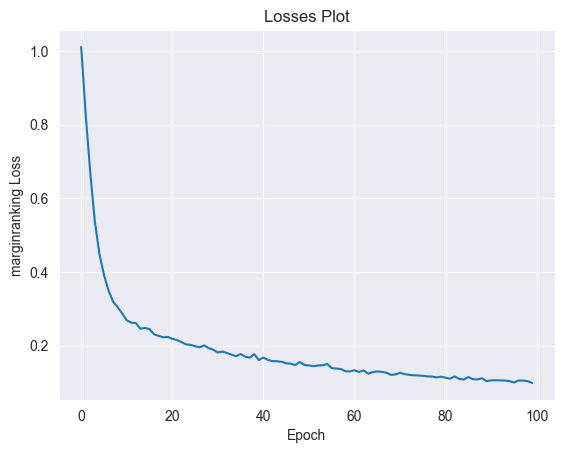

In [11]:
# wykres loss function
pipeline_result.plot_losses()

## Część 4. - rekomendacje

In [12]:
# funkcje pomocnicze
def print_movies(movie_ids: List[str], movies: Dict[str, Movie], print_missing=True):
    for m_id in movie_ids:
        if m_id in movies:
            print(movies[m_id].basic_info())
        elif print_missing:
            print(f'movie_id: {m_id}')

def describe_user(user_id: str, reviews: List[Review], movies: Dict[str, Movie]):
    positive_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating >= 4.0]
    negative_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating <= 2.0]
    neutral_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating > 2.0 and x.rating < 4.0]

    print(f'user_id: {user_id}')
    print('Positive ratings:')
    print_movies(positive_ratings, movies, print_missing=False)
    print('Neutral ratings:')
    print_movies(neutral_ratings, movies, print_missing=False)
    print('Negative ratings:')
    print_movies(negative_ratings, movies, print_missing=False)

In [13]:
from pykeen.predict import TargetPredictions

def recommend(user_id: str, model: ERModel, triples_factory: TriplesFactory, k: int) -> List[str]:
    relation = 'positive_rating'
    prediction: TargetPredictions = predict_target(model, head=user_id, relation=relation, triples_factory=triples_factory)
    # wygeneruj rekomendacje na podstawie predykcji
    df = prediction.df

    df = df[df['tail_label'].str.startswith('m_')]

    seen = {r.movie_id for r in ratings if r.user_id == user_id}
    df = df[~df['tail_label'].isin(seen)]
    df = df.nlargest(n = k, columns = 'score')
    return df['tail_label'].tolist()

def print_recommendation(recommendation: List[str], movies: Dict[str, Movie]):
    print_movies(recommendation, movies)

In [14]:
user_id = 'u_547' # uzytkownik z bardzo duza historia
# user_id = 'u_244'
describe_user(user_id, ratings, movies)
recommendation = recommend(user_id, pipeline_result.model, tf, 20)
print('Recommendation:')
print_recommendation(recommendation, movies)

user_id: u_547
Positive ratings:
{'movie_id': 'm_1965', 'title': 'A Perfect Murder', 'genres': ['Crime', 'Thriller', 'Drama'], 'production_countries': ['US']}
{'movie_id': 'm_919', 'title': 'Blood: The Last Vampire', 'genres': ['Fantasy', 'Animation', 'Horror', 'Comedy', 'Thriller', 'Science Fiction'], 'production_countries': ['JP']}
{'movie_id': 'm_51540', 'title': 'Horrible Bosses', 'genres': ['Comedy', 'Crime'], 'production_countries': ['US']}
{'movie_id': 'm_1244', 'title': 'Das wilde Leben', 'genres': ['Music', 'Drama', 'Comedy'], 'production_countries': ['DE']}
{'movie_id': 'm_1405', 'title': 'Greed', 'genres': ['Drama', 'History'], 'production_countries': ['US']}
{'movie_id': 'm_441', 'title': 'Human Nature', 'genres': ['Drama', 'Comedy'], 'production_countries': ['US']}
{'movie_id': 'm_2067', 'title': 'Mission to Mars', 'genres': ['Science Fiction'], 'production_countries': ['US']}
{'movie_id': 'm_866', 'title': 'Finding Neverland', 'genres': ['Drama'], 'production_countries': 

## Część 5. - metryki

In [ ]:
# HitRatio@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# dla kazdej oceny, generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy,
# czy oceniony film znalazl sie w rekomendacji.
# Zwracamy stosunek liczby trafien do liczby wszystkich prob

# wersja nieco bardziej zaawansowana - zamiast rekomendacji wyciagamy z modelu predykcje konkretnej relacji
# i liczymy skutecznosc w przewidywaniu, czy ocena byla pozytywna, negatywna czy neutralna

def hit_ratio(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int) -> float:
    positive_tests = [r for r in test_ratings if r.rating >= 4]

    hits = 0
    total = len(positive_tests)

    for review in positive_tests:
        user_id = review.user_id
        true_movie = review.movie_id

        prediction = predict_target(model, head=user_id, relation='positive_rating', triples_factory=tf)
        df = prediction.df
        df = df[df['tail_label'].str.startswith('m_')]
        top_k = df.nlargest(n = k, columns = 'score')['tail_label'].tolist()

        if true_movie in top_k:
            hits += 1

    if total == 0:
        return 0.0

    return hits / total

hit_ratio(test_ratings, pipeline_result.model, tf, 50)

0.1054335260115607

In [16]:
# AvgPosition@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# dla kazdej oceny, generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy,
# czy oceniony film znalazl sie w rekomendacji.
# Jesli tak, zapisujemy pozycje, na ktorej zarekomendowano film
# zwracamy srednia pozycje, na ktorych wystepowaly filmy

def avg_position(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int) -> float:
    positive_tests = [r for r in test_ratings if r.rating >= 4]
    sum_positions = 0
    count_hits = 0
    total = 0
    for review in positive_tests:
        if review.user_id not in tf.entity_to_id:
            continue
        total += 1
        prediction = predict_target(model, head=review.user_id, relation='positive_rating', triples_factory=tf)
        df = prediction.df
        df = df[df['tail_label'].str.startswith('m_')]
        top_k = df = df.nlargest(n = k, columns = 'score')['tail_label'].tolist()
        if review.movie_id in top_k:
            sum_positions += top_k.index(review.movie_id) + 1
            count_hits += 1
    if count_hits == 0:
        return 0.0
    return sum_positions / count_hits

avg_position(test_ratings, pipeline_result.model, tf, 50)

24.769736842105264

## Część 5. - porównanie modeli

Wytrenowaliśmy podstawowy model, umiemy wygenerować rekomendacje i ocenić jakość modelu. Teraz przeanalizujemy, jakie zmiany mogą pozytywnie wpłynąć na jakość rekomendacji.

Porównaj bazowy model (np. TransH wytrenowany tylko na relacjach `positive_rating` i `negative_rating`) z dwoma innymi podejściami. Wybierz dwie spośród poniszych modyfikacji lub zaproponuj własną:
1. Zmiana modelu - zamiast TransH możesz użyć np. TransR albo RESCAL
2. Dodanie większej liczby typów relacji - możesz dodać oceny neutralne, metadane filmu, informacje o obsadzie. Nawet jeśli jakaś relacja nie jest wykorzystywana w procesie rekomendacji, może poprawić jakość wytrenowanego modelu. Zwróć uwagę, by jako rekoemndację zwracać wyłącznie identyfikatory filmów, nie innych wierzchołków.
3. Zmiana sposobu rekomendacji - obecny tryb opiera się na przewidywaniu relacji `positive_rating`. Możesz poprawić ten proces przez np. odsiewanie tych kandydatów, którzy występują także w predykcji relacji `negative_rating` czy filtrowanie kandydatów po metadanych (np. gatunku).

Porównanie trzech modeli oprzyj na dwóch zdefiniowanych w Części 4. metrykach dla wybranej wartości `k`.

In [17]:
from pykeen.models import TransR


def train_model_TransR(triples: List[Tuple[str, str, str]], tf: TriplesFactory):
    training, testing, validation = tf.split([.8, .1, .1])

    pipeline_result = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        model=TransR,
        epochs=100
    )
    return pipeline_result

pipeline_result_transR = train_model_TransR(triples, tf)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [18238, 2441, 2442]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/77.0 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/2.44k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 5.08s seconds


In [18]:
hit_ratio(test_ratings, pipeline_result_transR.model, tf, 50)

0.05341040462427746

In [19]:
avg_position(test_ratings, pipeline_result_transR.model, tf, 50)

25.761904761904763

In [20]:
triples = generate_triples(train_ratings, movies, all_relation_types)
print(triples)
tf = TriplesFactory.from_labeled_triples(np.array(triples))

[('u_188', 'positive_rating', 'm_597'), ('u_56', 'positive_rating', 'm_926'), ('u_564', 'positive_rating', 'm_2014'), ('u_380', 'positive_rating', 'm_592'), ('u_472', 'positive_rating', 'm_1272'), ('u_311', 'positive_rating', 'm_1393'), ('u_433', 'positive_rating', 'm_6016'), ('u_351', 'positive_rating', 'm_1269'), ('u_312', 'positive_rating', 'm_1267'), ('u_564', 'positive_rating', 'm_1091'), ('u_48', 'positive_rating', 'm_3578'), ('u_220', 'positive_rating', 'm_272'), ('u_141', 'positive_rating', 'm_480'), ('u_409', 'positive_rating', 'm_204'), ('u_247', 'positive_rating', 'm_2959'), ('u_592', 'positive_rating', 'm_104'), ('u_308', 'positive_rating', 'm_454'), ('u_441', 'positive_rating', 'm_541'), ('u_547', 'positive_rating', 'm_1965'), ('u_564', 'positive_rating', 'm_2110'), ('u_78', 'positive_rating', 'm_316'), ('u_608', 'positive_rating', 'm_532'), ('u_373', 'positive_rating', 'm_5060'), ('u_213', 'positive_rating', 'm_1544'), ('u_188', 'positive_rating', 'm_296'), ('u_461', 'pos

In [21]:
pipeline_result = train_model(triples, tf)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [30332, 6281, 6281]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/197 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
hit_ratio(test_ratings, pipeline_result.model, tf, 50)

0.10893398647072546

In [ ]:
avg_position(test_ratings, pipeline_result.model, tf, 50)

22.916488222698074